In [2]:
from utils.marvl_preproc import marvl_preproc
import argparse
import os
import sys
import math
import pandas as pd
from sklearn import metrics
from collections import defaultdict

import ruamel.yaml as yaml
import numpy as np
import random
import time
from tqdm import tqdm
import datetime
import json
from pathlib import Path
import json
import pickle

import torch
import torch.backends.cudnn as cudnn
import torch.distributed as dist

from models.model_nlvr import NLVRModel

import utils
from dataset import create_dataset, create_sampler, create_loader, build_tokenizer
from scheduler import create_scheduler
from optim import create_optimizer
from models.model_pretrain_cclm import CrossViewLM

from torch.utils.data import DataLoader,WeightedRandomSampler
from torchvision import transforms

from torchvision.transforms import InterpolationMode
from dataset.randaugment import RandomAugment

from dataset.nlvr_dataset import nlvr_dataset

import matplotlib.pyplot as plt
from PIL import Image
from transformers import AutoTokenizer, AutoModelForMaskedLM
from models import build_mlp
import re
from collections import OrderedDict
from optim import create_optimizer
from torch.utils.data import Dataset
from torchvision.io import read_image
device = 'cuda'
import random
from sklearn.metrics import precision_recall_curve

from functools import partial
from multiprocessing import Pool
from collections import defaultdict


from useful_functions import *

/home/kh3074/anaconda3/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [18]:
# load configs and checkpoints
#config = yaml.load(open('configs/Pretrain_3m.yaml', 'r'), Loader=yaml.Loader)
config = yaml.load(open('configs/Pretrain_4m.yaml', 'r'), Loader=yaml.Loader)
#checkpoint = torch.load('data/cclm_3m_epoch_29.th', map_location=device)
#checkpoint = torch.load('data/cclm_4m_epoch_29.th', map_location=device) # for training, need to load this

# dataset transformations
normalize = transforms.Normalize((0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711))

train_transform = transforms.Compose([
    transforms.CenterCrop(config['image_res'],# scale=(0.5, 1.0),
                                 #interpolation=InterpolationMode.BICUBIC
                         ),
    #transforms.RandomHorizontalFlip(),
    RandomAugment(2, 7, isPIL=True, augs=['Identity', 'Brightness', 'Sharpness',
                                          'TranslateX', 'TranslateY']),
    transforms.ToTensor(),
    normalize,
])

val_transform = transforms.Compose([
    transforms.Resize((config['image_res'], config['image_res']), interpolation=InterpolationMode.BICUBIC),
    transforms.ToTensor(),
    normalize,
])


#val_video_num = 50

#csv_file = pd.read_csv(csv_file_path)
#
#file_ids = list(set(list(csv_file.file_id)))
#random.seed(seed)
#
#val_videos = random.sample(file_ids, val_video_num)
#
#csv_file['train_test'] = csv_file['file_id'].apply(lambda x: 'val' if x in val_videos else 'train')
def evaluation_full_csv(model,dataset):
    print(f'total num of {len(dataset)} datapoints need to be evaluated!')
    file_ids = []
    start_time_stamps = []
    end_time_stamps = []
    start_img_paths = []
    img_end_paths = []
    true_labels = []
    pred_labels = []
    logi_positive = []
    logi_negative = []
    texts = []

    for idx in range(len(dataset)-1):
        image0, image1, text, targets, data_pair_info = dataset[idx]
        # file_information
        file_id = data_pair_info.file_id
        img_start_path = data_pair_info.img_start
        start_stamp = data_pair_info['time_start']
        img_end_path = data_pair_info.img_end
        end_stamp = data_pair_info['time_end']
        image0 = image0.unsqueeze(0).to(device)
        image1 = image1.unsqueeze(0).to(device)
        #text = text.unsqueeze(0)
        targets = torch.Tensor([targets]).to(device)
        # do one forward prediction
        images = torch.cat([image0, image1], dim = 0)
        text_inputs = tokenizer(text, padding='longest', return_tensors="pt").to(device)
        prediction = model(images, text_inputs.input_ids, text_inputs.attention_mask, targets=targets, train=False)
        _, pred_class = prediction.max(1)
        # change linear output to softmax
        pred_logi = my_softmax(prediction)
        if idx%500==0:
            print(f'Just finished sample No.{idx}')
        file_ids.append(file_id)
        start_time_stamps.append(start_stamp)
        end_time_stamps.append(end_stamp)
        start_img_paths.append(img_start_path)
        img_end_paths.append(img_end_path)
        true_labels.append(int(targets.item()))
        pred_labels.append(int(pred_class.item()))
        logi_positive.append(pred_logi[0][1].item())
        logi_negative.append(pred_logi[0][0].item())
        texts.append(text)
    return pd.DataFrame({'file_ids':file_ids,
                          'start_time_stamps':start_time_stamps,
                          'end_time_stamps':end_time_stamps,
                          'start_img_paths':start_img_paths,
                          'img_end_paths':img_end_paths,
                          'true_labels':true_labels,
                          'pred_labels':pred_labels,
                          'logi_positive':logi_positive,
                          'logi_negative':logi_negative,
                          'texts':texts
                            })
def calculate_matrix(csv):
    correct_pred = csv[csv['true_labels'] == csv['pred_labels']]
    wrong_pred = csv[csv['true_labels'] != csv['pred_labels']]
    true_positive = correct_pred[correct_pred['true_labels'] == 1]
    false_positive = wrong_pred[wrong_pred['true_labels'] == 0]
    true_negative = correct_pred[correct_pred['true_labels'] == 0]
    false_negative = wrong_pred[wrong_pred['true_labels'] == 1]
    
    precision = len(true_positive)/(len(false_positive)+len(true_positive)+0.000001)
    recall = len(true_positive)/(len(true_positive)+len(false_negative)+0.000001)
    accuracy = len(correct_pred)/(len(correct_pred)+len(wrong_pred))
    precision_auc, recall_auc, thresholds = precision_recall_curve(list(csv.true_labels),list(csv.logi_positive))
    pr_auc = auc(recall_auc, precision_auc)
    print(f'confusion matrix:\n{[len(true_positive), len(false_negative)]}\n{[len(false_positive), len(true_negative)]}')
    print('-----------------------------------------')
    print(f'recall is: {recall}, precision is: {precision}')
    print(f'Accuracy is {accuracy}')

    return recall, precision, accuracy, pr_auc, list(precision_auc), list(recall_auc)
def eval_on_dataset(model,data_loader,device,tokenizer):
    results = []
    clock_start = time.time()
    with torch.no_grad():  
        for cur_idx, batch in enumerate(data_loader):
            images = torch.cat([batch[0], batch[1]], dim=0)
            targets = batch[3]
            images, targets = images.to(device), targets.to(device)   

            text_inputs = tokenizer(batch[2], padding='longest', return_tensors="pt").to(device)  
            predictions = model(images, text_inputs.input_ids, text_inputs.attention_mask, targets=targets, train=False)
            pred_logis = nn.functional.softmax(predictions, dim=1)
            predicted_classes = torch.argmax(pred_logis, dim=1)
            
            for batch_idx in range(len(predictions)):
                data_pair_info = batch[4][batch_idx]
                file_id = data_pair_info.file_id
                img_start_path = data_pair_info.img_start
                start_stamp = data_pair_info.time_start
                img_end_path = data_pair_info.img_end
                end_stamp = data_pair_info.time_end
                results.append({
                'file_ids': file_id,
                'start_time_stamps': start_stamp,
                'end_time_stamps': end_stamp,
                'start_img_paths': img_start_path,
                'img_end_paths': img_end_path,
                'true_labels': targets[batch_idx].item(),
                'pred_labels': predicted_classes[batch_idx].item(),
                'logi_positive': pred_logis[batch_idx][1].item(),
                'logi_negative': pred_logis[batch_idx][0].item(),
                'texts': batch[2][batch_idx]
                })
            clock_end = time.time()
            clock_time_used = round(round(clock_end - clock_start,4)/(cur_idx+1),4)
            print(f'current batch: {cur_idx}, total_batch: {len(data_loader)}, average_eval_time_per_batch: {clock_time_used}',end='\r')
    return pd.DataFrame(results)

def test_a_model(model_path):
    #load trained model
    my_nvlr_model_loaded = NLVRModel(config=config)
    checkpoint_ldc = torch.load(model_path, map_location=device)
    my_nvlr_model_loaded.load_state_dict(checkpoint_ldc) # load_nlvr_pretrain= False because current checkpoint is CCLM model
    my_nvlr_model_loaded.to(device)
    train_result_csv = evaluation_full_csv(my_nvlr_model_loaded, train_dataset)
    calculate_matrix(train_result_csv)
    val_result_csv = evaluation_full_csv(my_nvlr_model_loaded, val_dataset)
    calculate_matrix(val_result_csv)
    return train_result_csv, val_result_csv

def prepare_refs(val_dataset):
    refs = []
    fileid_list = list(val_dataset.keys())
    for file_id in fileid_list:
        change_points = val_dataset[file_id]['changepoints']
        for change_point in change_points:
            new_changepoint = {'file_id':file_id,
                              'timestamp':change_point['timestamp'],
                              'type':val_dataset[file_id]['data_type'],
                              'impact_scalar':change_point['impact_scalar']}
            refs.append(new_changepoint)
    return refs
def prepare_hyps(eval_df, threshold):
    hyps = []
    eval_df = eval_df[eval_df.apply(lambda row: row['logi_positive'] > threshold, axis=1)]
    for row_idx in range(len(eval_df)):
        row = eval_df.iloc[row_idx,:]
        pred_change_point = {'file_id':row['file_ids'],
                            'timestamp':(row['start_time_stamps']+row['end_time_stamps'])/2,
                            'type': 'video',
                            'llr': math.log(row['logi_positive']/row['logi_negative'])}
        hyps.append(pred_change_point)
    return hyps
sys.path.append('nist_scorer')
from nist_scorer.CCU_validation_scoring.score_changepoint import score_cp


def filter_file_system_preds(file_system_preds, text_char_threshold, time_sec_threshold, filtering):
    file_system_preds = list(sorted(
        file_system_preds,
        key=lambda file_pred: float(file_pred['timestamp'])
    ))

    if len(file_system_preds) <= 1:
        return file_system_preds

    if file_system_preds[0]['type'] == 'text':
        distance_threshold = text_char_threshold
    else:
        assert file_system_preds[0]['type'] in {'audio', 'video'}
        distance_threshold = time_sec_threshold

    to_remove = set()
    while True:
        candidates = []
        remaining_idxs = list(sorted(set(range(len(file_system_preds))) - to_remove))

        if len(remaining_idxs) <= 1:
            break

        for i in range(len(remaining_idxs)):
            distance_before, distance_after = -1, -1

            remaining_idx = remaining_idxs[i]
            if i > 0:
                before_idx = remaining_idxs[i - 1]
                distance_before = file_system_preds[remaining_idx]['timestamp'] - file_system_preds[before_idx][
                    'timestamp']
            else:
                before_idx = None

            if i < len(remaining_idxs) - 1:
                after_idx = remaining_idxs[i + 1]
                distance_after = file_system_preds[after_idx]['timestamp'] - file_system_preds[remaining_idx][
                    'timestamp']
            else:
                after_idx = None

            # if the adjacent predictions are too close, we should consider removing it
            if max(distance_before, distance_after) < distance_threshold:
                if filtering == 'highest':
                    sort_key = -1 * float(file_system_preds[remaining_idx]['llr'])
                elif filtering == 'lowest':
                    sort_key = float(file_system_preds[remaining_idx]['llr'])
                elif filtering == 'most_similar':
                    sort_key = -1 * math.inf
                    if before_idx is not None:
                        sort_key = max(
                            sort_key,
                            abs(
                                float(file_system_preds[remaining_idx]['llr']) -
                                float(file_system_preds[before_idx]['llr'])
                            )
                        )

                    if after_idx is not None:
                        sort_key = max(
                            sort_key,
                            abs(
                                float(file_system_preds[remaining_idx]['llr']) -
                                float(file_system_preds[after_idx]['llr'])
                            )
                        )
                else:
                    raise ValueError(f'Unknown filtering type: {filtering}')

                candidates.append((sort_key, remaining_idx))

        if len(candidates) == 0:
            break

        candidates = list(sorted(candidates))
        to_remove.add(candidates[0][1])

    return [
        file_system_preds[i] for i in range(len(file_system_preds)) if i not in to_remove
    ]


def filter_system_preds(system_preds, text_char_threshold, time_sec_threshold, filtering, n_jobs=16):
    if filtering == 'none':
        return system_preds

    assert filtering in {'highest', 'lowest', 'most_similar'}

    by_file = defaultdict(list)
    for system_pred in system_preds:
        by_file[system_pred['file_id']].append(system_pred)

    if n_jobs == 1:
        filtered_system_preds = []
        for file_id, file_system_preds in tqdm(by_file.items(), desc='filtering system predictions', leave=False):
            filtered_system_preds.extend(
                filter_file_system_preds(file_system_preds, text_char_threshold, time_sec_threshold, filtering)
            )
    else:
        by_file_preds = list(by_file.values())
        random.shuffle(by_file_preds)
        with Pool(n_jobs) as pool:
            filtered_system_preds = list(
                tqdm(
                    pool.imap_unordered(
                        partial(
                            filter_file_system_preds,
                            text_char_threshold=text_char_threshold,
                            time_sec_threshold=time_sec_threshold,
                            filtering=filtering
                        ),
                        by_file_preds,
                        chunksize=50
                    ),
                    total=len(by_file_preds),
                    desc='filtering system predictions',
                    leave=False
                )
            )
        filtered_system_preds = [
            system_pred for file_system_preds in filtered_system_preds
            for system_pred in file_system_preds
        ]

    return filtered_system_preds


# refs: array of gold-label LDC references
#   [
#       {
#           'file_id': the LDC file identifier for this changepoint
#           'timestamp': the timestamp of the annotated changepoint
#           'impact_scalar': the impact scalar of the annotated changepoint
#           'type': one of audio / video / text
#       }
#   ]
#   ex:
#       [
#           {'file_id': 'M010015BY', 'timestamp': 1160.2, 'type': 'audio', 'impact_scalar': 4},
#           {'file_id': 'M010015BY', 'timestamp': 1287.6, 'type': 'audio', 'impact_scalar': 2},
#           {'file_id': 'M010029SP', 'timestamp': 288.0, 'type': 'text', 'impact_scalar': 1},
#           {'file_id': 'M010005QD', 'timestamp': 90.2, 'type': 'video', 'impact_scalar': 5},
#           {'file_id': 'M010019QD', 'timestamp': 90, 'type': 'text', 'impact_scalar': 5}
#       ]
# hyps: array of system predictions
#   [
#       {
#           'file_id': the LDC file identifier for this changepoint
#           'timestamp': the timestamp of the annotated changepoint
#           'type': one of audio / video / text
#           'llr': the log-likelihood ratio of the predicted changepoint
#       }
#   ]
#   ex:
#       [
#           {'file_id': 'M010015BY', 'timestamp': 1160.2, 'type': 'audio', 'llr': 1.5},
#           {'file_id': 'M010015BY', 'timestamp': 1287.67, 'type': 'audio', 'llr': 1.5},
#           {'file_id': 'M010029SP', 'timestamp': 288, 'type': 'text', 'llr': 1.5},
#           {'file_id': 'M010005QD', 'timestamp': 90.2, 'llr': 1.5, 'type': 'video'},
#           {'file_id': 'M010019QD', 'timestamp': 190, 'llr': 1.5, 'type': 'text'}
#       ]
# returns a dictionary with an AP score for each document type (audio, video, text)
def calculate_average_precision(
        refs, hyps,
        text_char_threshold=100,
        time_sec_threshold=10,
        filtering='none',
        n_jobs=16
):
    hyps = filter_system_preds(
        hyps, text_char_threshold,
        time_sec_threshold, filtering, n_jobs=n_jobs
    )

    # NIST uses non-zero values of "Class" to indicate annotations / predictions
    # in LDC's randomly selected annotation regions
    for ref in refs:
        ref['Class'] = ref['timestamp']
        ref['start'] = ref['timestamp']
        ref['end'] = ref['timestamp']

    for hyp in hyps:
        hyp['Class'] = hyp['timestamp']
        hyp['start'] = hyp['timestamp']
        hyp['end'] = hyp['timestamp']

    ref_df = pd.DataFrame.from_records(refs)
    hyp_df = pd.DataFrame.from_records(hyps)

    output_dir = 'tmp_scoring_%s' % os.getpid()
    os.makedirs(output_dir, exist_ok=True)

    score_cp(
        ref_df, hyp_df,
        delta_cp_text_thresholds=[text_char_threshold],
        delta_cp_time_thresholds=[time_sec_threshold],
        output_dir=output_dir
    )

    APs, score_df = {}, pd.read_csv(
        os.path.join(output_dir, 'scores_by_class.tab'), delimiter='\t'
    )
    for _, row in score_df[score_df['metric'] == 'AP'].iterrows():
        APs[row['genre']] = float(row['value'])

    shutil.rmtree(output_dir)

    return APs
def show_data_df(df):
    pred_points = []
    logis = []
    change_points = []
    logits_of_positive = []
    for idx in range(len(df)):
        row = df.iloc[idx,:]
        if row.true_labels == 1:
            change_points.append((float(row.start_time_stamps)+float(row.end_time_stamps))/2)
            logits_of_positive.append(row.logi_positive)

        pred_points.append((float(row.start_time_stamps)+float(row.end_time_stamps))/2)
        logis.append(row.logi_positive)

    plt.scatter(pred_points,logis, c = 'black', alpha = 0.1)
    plt.scatter(change_points,np.ones_like(change_points), c = 'red', s = 10, alpha = 0.5)
    plt.scatter(change_points,logits_of_positive, c = 'yellow', s = 10, alpha = 0.5)
    plt.axhline(y = 0.5, c = 'cyan')
    plt.xlabel('time stamp')
    plt.ylabel('positive logit')
    plt.show()

In [4]:
data_path = '/mnt/swordfish-pool2/ccu/amith-cache.pkl'
with open(data_path, 'rb') as handle:
    dataset = pickle.load(handle)

# delete file without jpgs
keys_to_remove = []
for key in dataset.keys():
    if dataset[key]['data_type'] !='video':
        keys_to_remove.append(key)
    elif dataset[key]['processed'] == False:
        keys_to_remove.append(key)
for key in keys_to_remove:
    del dataset[key]

# train val test split
train_dataset = {}
val_dataset = {}
test_dataset = {}
final_eval_dataset = {}
for key in dataset.keys():
    if 'INTERNAL_TRAIN' in dataset[key]['splits']:
        train_dataset.update({key:dataset[key]})
    if 'EVALUATION_LDC2023E07' in dataset[key]['splits']:
        final_eval_dataset.update({key:dataset[key]})
    if 'INTERNAL_VAL' in dataset[key]['splits']:
        val_dataset.update({key:dataset[key]})
    if 'INTERNAL_TEST' in dataset[key]['splits']:
        test_dataset.update({key:dataset[key]})


print(len(dataset), len(train_dataset), len(val_dataset), len(test_dataset), len(final_eval_dataset))

7474 2567 323 317 5001


In [11]:
balance_train_result = pd.read_csv('/mnt/swordfish-pool2/kh3074/train_cls_head_first/evaluate_results/inference_result_INTERNAL_VAL_5_9_16')
imbalance_train_result = pd.read_csv('/mnt/swordfish-pool2/kh3074/neg_pos_rate2/evaluate_results/inference_result_INTERNAL_VAL_5_9_16')
context_train_result = pd.read_csv('/mnt/swordfish-pool2/kh3074/with_context/evaluate_results/inference_result_INTERNAL_VAL_5_9_16')

In [12]:
balance_train_result_test = pd.read_csv('/mnt/swordfish-pool2/kh3074/train_cls_head_first/evaluate_results/inference_result_INTERNAL_TEST_5_9_20')
imbalance_train_result_test = pd.read_csv('/mnt/swordfish-pool2/kh3074/neg_pos_rate2/evaluate_results/inference_result_INTERNAL_TEST_5_9_20')
context_train_result_test = pd.read_csv('/mnt/swordfish-pool2/kh3074/with_context/evaluate_results/inference_result_INTERNAL_TEST_5_9_20')

# Val

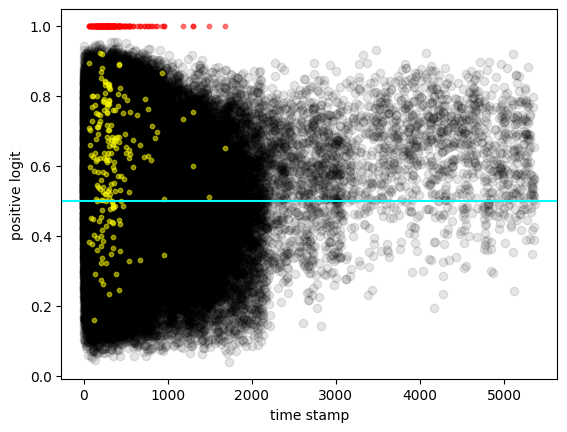

cur filter mood:none
cur filter mood:highest


cur filter mood:lowest


cur filter mood:most_similar


[{'video': 0.018094386366746415}, {'video': 0.01861462599690412}, {'video': 0.022171506979782554}, {'video': 0.023024187865472303}]


In [6]:
# balance_train_result
show_data_df(balance_train_result)
filter_moods = ['none','highest', 'lowest', 'most_similar']
ap_results = []
ref_val_dataset = prepare_refs(val_dataset)
hyp_result = prepare_hyps(balance_train_result,0)
for filter_mood in filter_moods:
    print(f'cur filter mood:{filter_mood}')
    result_ap = calculate_average_precision(
            ref_val_dataset, hyp_result,
            text_char_threshold=100,
            time_sec_threshold=10,
            filtering=filter_mood
    )
    ap_results.append(result_ap)
print(ap_results)

In [19]:
_ = calculate_matrix(balance_train_result)

confusion matrix:
[145, 47]
[72124, 49378]
-----------------------------------------
recall is: 0.7552083293999566, precision is: 0.002006392782493097
Accuracy is 0.40694693246996566


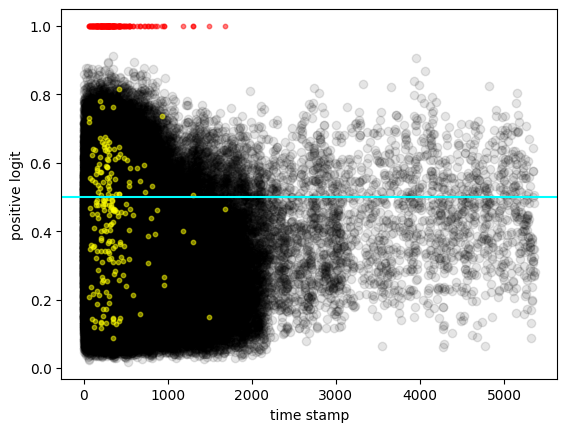

cur filter mood:none
cur filter mood:highest


cur filter mood:lowest


cur filter mood:most_similar


[{'video': 0.015897770064119517}, {'video': 0.01763139401632261}, {'video': 0.021003476428462772}, {'video': 0.02377038823718114}]


In [7]:
# imbalance_train_result
show_data_df(imbalance_train_result)
filter_moods = ['none','highest', 'lowest', 'most_similar']
ap_results = []
ref_val_dataset = prepare_refs(val_dataset)
hyp_result = prepare_hyps(imbalance_train_result,0)
for filter_mood in filter_moods:
    print(f'cur filter mood:{filter_mood}')
    result_ap = calculate_average_precision(
            ref_val_dataset, hyp_result,
            text_char_threshold=100,
            time_sec_threshold=10,
            filtering=filter_mood
    )
    ap_results.append(result_ap)
print(ap_results)

In [20]:
_ = calculate_matrix(imbalance_train_result)

confusion matrix:
[70, 122]
[23672, 97830]
-----------------------------------------
recall is: 0.3645833314344618, precision is: 0.002948361553241161
Accuracy is 0.8044768024717734


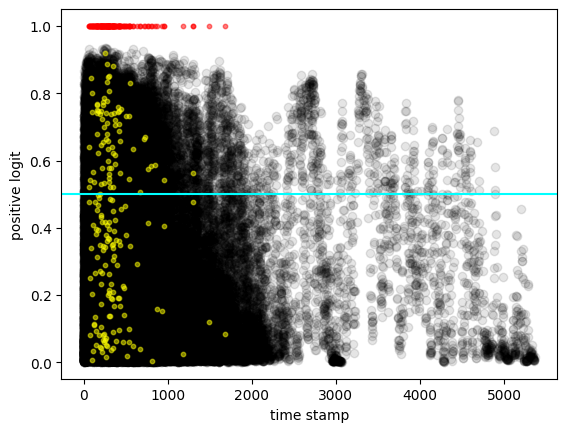

cur filter mood:none
cur filter mood:highest


cur filter mood:lowest


cur filter mood:most_similar


[{'video': 0.01442950678422381}, {'video': 0.022530339745899366}, {'video': 0.025831333221137252}, {'video': 0.0261685537677602}]


In [8]:
# train with context
show_data_df(context_train_result)
filter_moods = ['none','highest', 'lowest', 'most_similar']
ap_results = []
ref_val_dataset = prepare_refs(val_dataset)
hyp_result = prepare_hyps(context_train_result,0)
for filter_mood in filter_moods:
    print(f'cur filter mood:{filter_mood}')
    result_ap = calculate_average_precision(
            ref_val_dataset, hyp_result,
            text_char_threshold=100,
            time_sec_threshold=10,
            filtering=filter_mood
    )
    ap_results.append(result_ap)
print(ap_results)

In [21]:
_ = calculate_matrix(context_train_result)

confusion matrix:
[79, 113]
[24970, 96532]
-----------------------------------------
recall is: 0.4114583311903212, precision is: 0.003153818515583304
Accuracy is 0.793884661528095


# Test

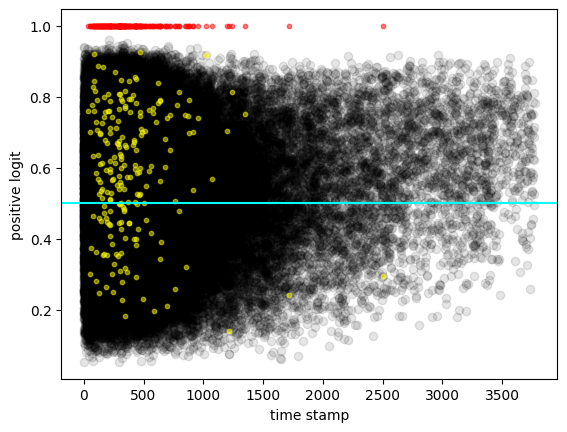

cur filter mood:none
cur filter mood:highest


cur filter mood:lowest


cur filter mood:most_similar


In [ ]:
show_data_df(balance_train_result_test)
filter_moods = ['none','highest', 'lowest', 'most_similar']
ap_results = []
ref_val_dataset = prepare_refs(test_dataset)
hyp_result = prepare_hyps(balance_train_result_test,0)
for filter_mood in filter_moods:
    print(f'cur filter mood:{filter_mood}')
    result_ap = calculate_average_precision(
            ref_val_dataset, hyp_result,
            text_char_threshold=100,
            time_sec_threshold=10,
            filtering=filter_mood
    )
    ap_results.append(result_ap)
print(ap_results)

In [ ]:
_ = calculate_matrix(balance_train_result_test)

In [ ]:
show_data_df(imbalance_train_result_test)
filter_moods = ['none','highest', 'lowest', 'most_similar']
ap_results = []
ref_val_dataset = prepare_refs(test_dataset)
hyp_result = prepare_hyps(imbalance_train_result_test,0)
for filter_mood in filter_moods:
    print(f'cur filter mood:{filter_mood}')
    result_ap = calculate_average_precision(
            ref_val_dataset, hyp_result,
            text_char_threshold=100,
            time_sec_threshold=10,
            filtering=filter_mood
    )
    ap_results.append(result_ap)
print(ap_results)

In [ ]:
_ = calculate_matrix(imbalance_train_result_test)

In [ ]:
show_data_df(context_train_result_test)
filter_moods = ['none','highest', 'lowest', 'most_similar']
ap_results = []
ref_val_dataset = prepare_refs(test_dataset)
hyp_result = prepare_hyps(context_train_result_test,0)
for filter_mood in filter_moods:
    print(f'cur filter mood:{filter_mood}')
    result_ap = calculate_average_precision(
            ref_val_dataset, hyp_result,
            text_char_threshold=100,
            time_sec_threshold=10,
            filtering=filter_mood
    )
    ap_results.append(result_ap)
print(ap_results)

In [ ]:
_ = calculate_matrix(context_train_result_test)